<a href="https://colab.research.google.com/github/keithferns98/ML_Models/blob/main/BoostingAlgor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import xgboost
import math
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
#from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import learning_curve as curve
from time import time
from sklearn.metrics import r2_score

In [ ]:
df=pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df_train=df.copy()
df_train.rename(columns={'price':'SalePrice'},inplace=True)

In [ ]:
df_train.head()

,id,date,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#STEP2 DATA CLEANING AND PREPROCESSING
STEP 2: DATA CLEANING AND PREPROCESSING

In this step we check whether data contain null or missing values. What is the size of the data. What is the datatype of each column. What are unique values of categorical variables etc.

In [ ]:
print(df_train.shape)
print("-------------------------------")
print(f'DataFrame_Cols are\n,{df_train.columns}')
print("-------------------------------")
print(df_train.info())

(21613, 21)
-------------------------------
DataFrame_Cols are
,Index(['id', 'date', 'SalePrice', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   SalePrice      21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view  

In [ ]:
df_train.describe()

,id,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [ ]:
df_train.isnull().sum()

id               0
date             0
SalePrice        0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

STEP 3 : FINDING CORRELATION

In this step we check by finding correlation of all the features wrt target variable i.e., price to see whether they are positively correlated or negatively correlated to find if they help in prediction process in model building process or not. But this is also one of the most important step as it also involves domain knowledge of the field of the data means you cannot simply remove the feature from your prediction process just because it is negatively correlated because it may contribute in future prediction for this you should take help of some domain knowledge personnel.

In [ ]:
# As id and date columns are not important to predict price 
#so we are discarding it for finding correlation

features=df_train.iloc[:,3:].columns.to_list()
target=df_train.iloc[:,2].name

In [ ]:
# As id and date columns are not important
#to predict price so we are discarding it for finding correlation
correlations={}
for f in features:
    data_temp=df_train[[f,target]]
    x1=data_temp[f].values
    x2=data_temp[target].values
    key=f+'vs'+target
    correlations[key]=pearsonr(x1,x2)[0]

In [ ]:
target

'SalePrice'

In [ ]:
# As id and date columns are not important to predict price so we are discarding it for finding correlation
data_correlations=pd.DataFrame(correlations,index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_livingvsSalePrice,0.702035
gradevsSalePrice,0.667434
sqft_abovevsSalePrice,0.605567
sqft_living15vsSalePrice,0.585379
bathroomsvsSalePrice,0.525138
viewvsSalePrice,0.397293
sqft_basementvsSalePrice,0.323816
bedroomsvsSalePrice,0.308350
latvsSalePrice,0.307003
waterfrontvsSalePrice,0.266369


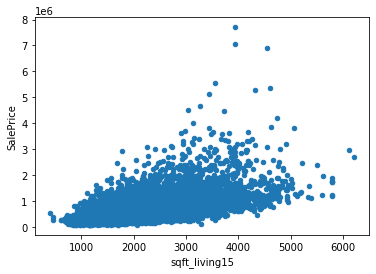

In [ ]:
var='sqft_living15'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice')

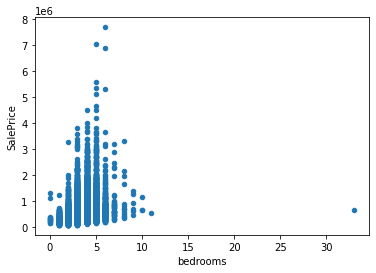

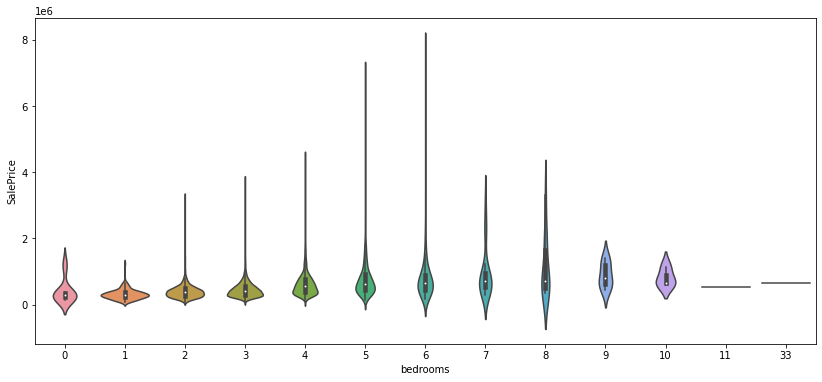

In [ ]:
var='bedrooms'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(y='SalePrice',x=var)
f,ax=plt.subplots(figsize=(14,6))
fig=sns.violinplot(x=var,y="SalePrice",data=data)


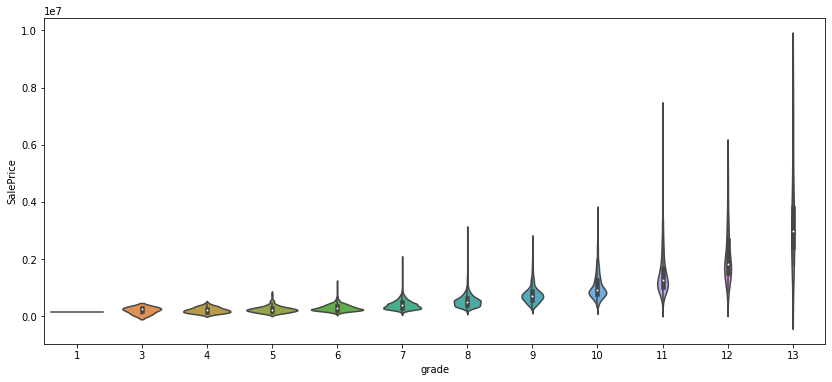

In [ ]:
var='grade'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
f,ax=plt.subplots(figsize=(14,6))
fig=sns.violinplot(x=var,y='SalePrice',data=data)


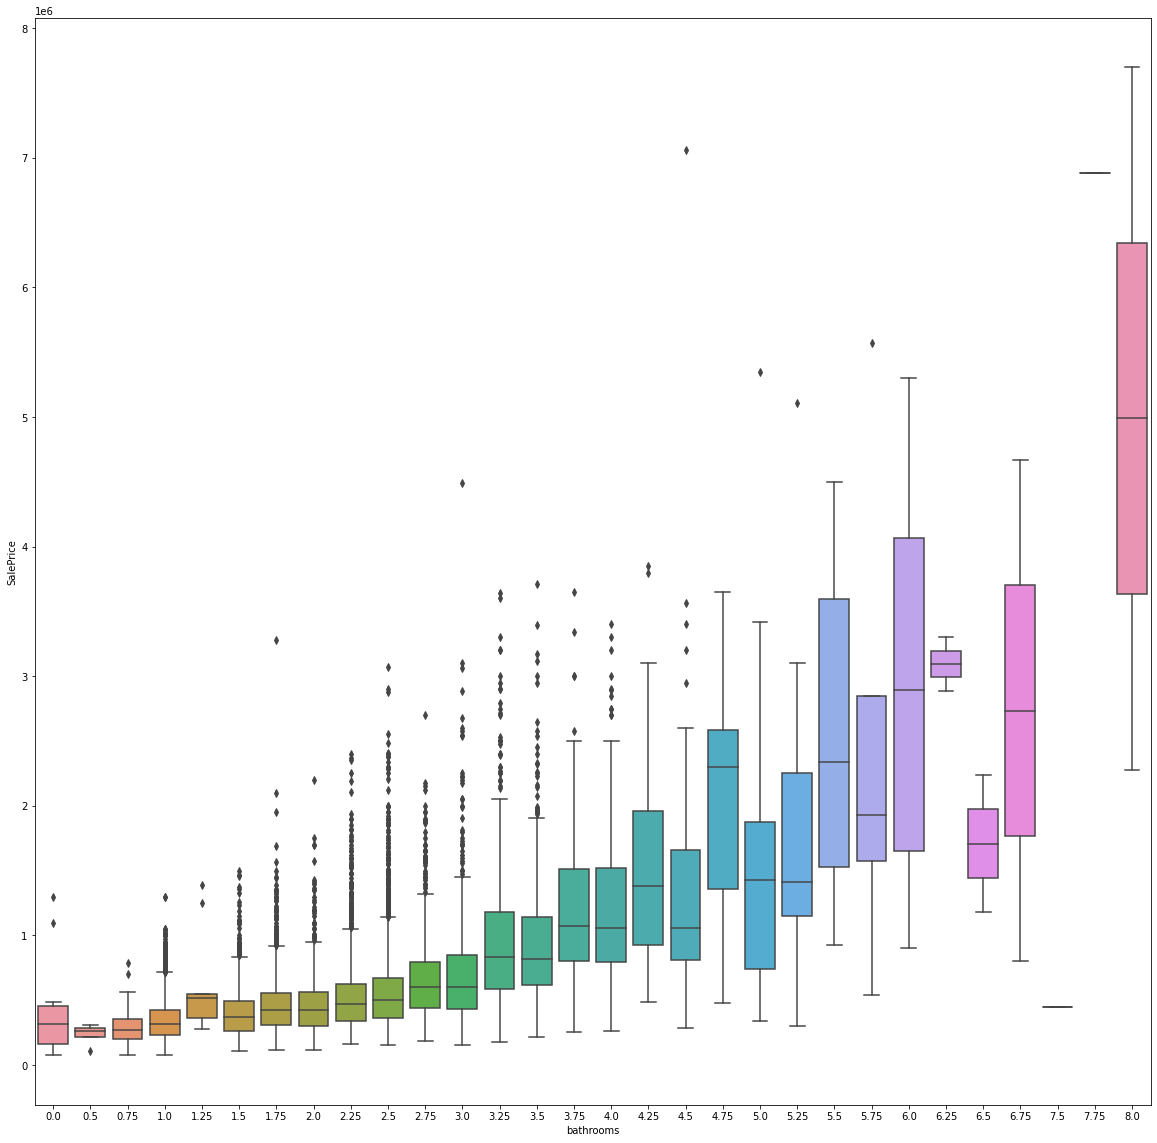

In [ ]:
var='bathrooms'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
f,ax=plt.subplots(figsize=(20,20))
fig=sns.boxplot(x=var,y='SalePrice',data=data)

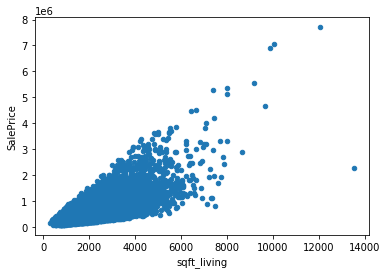

In [ ]:
var = 'sqft_living'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice');

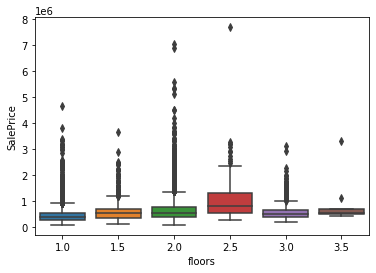

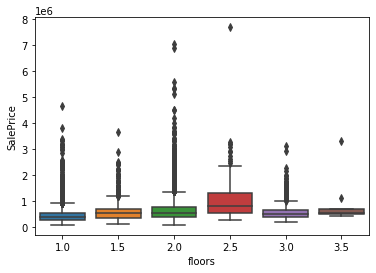

In [ ]:
var='floors'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
#f,ax=plt.subplots(figsize=(20,20))
fig=sns.boxplot(x=var,y='SalePrice',data=data)

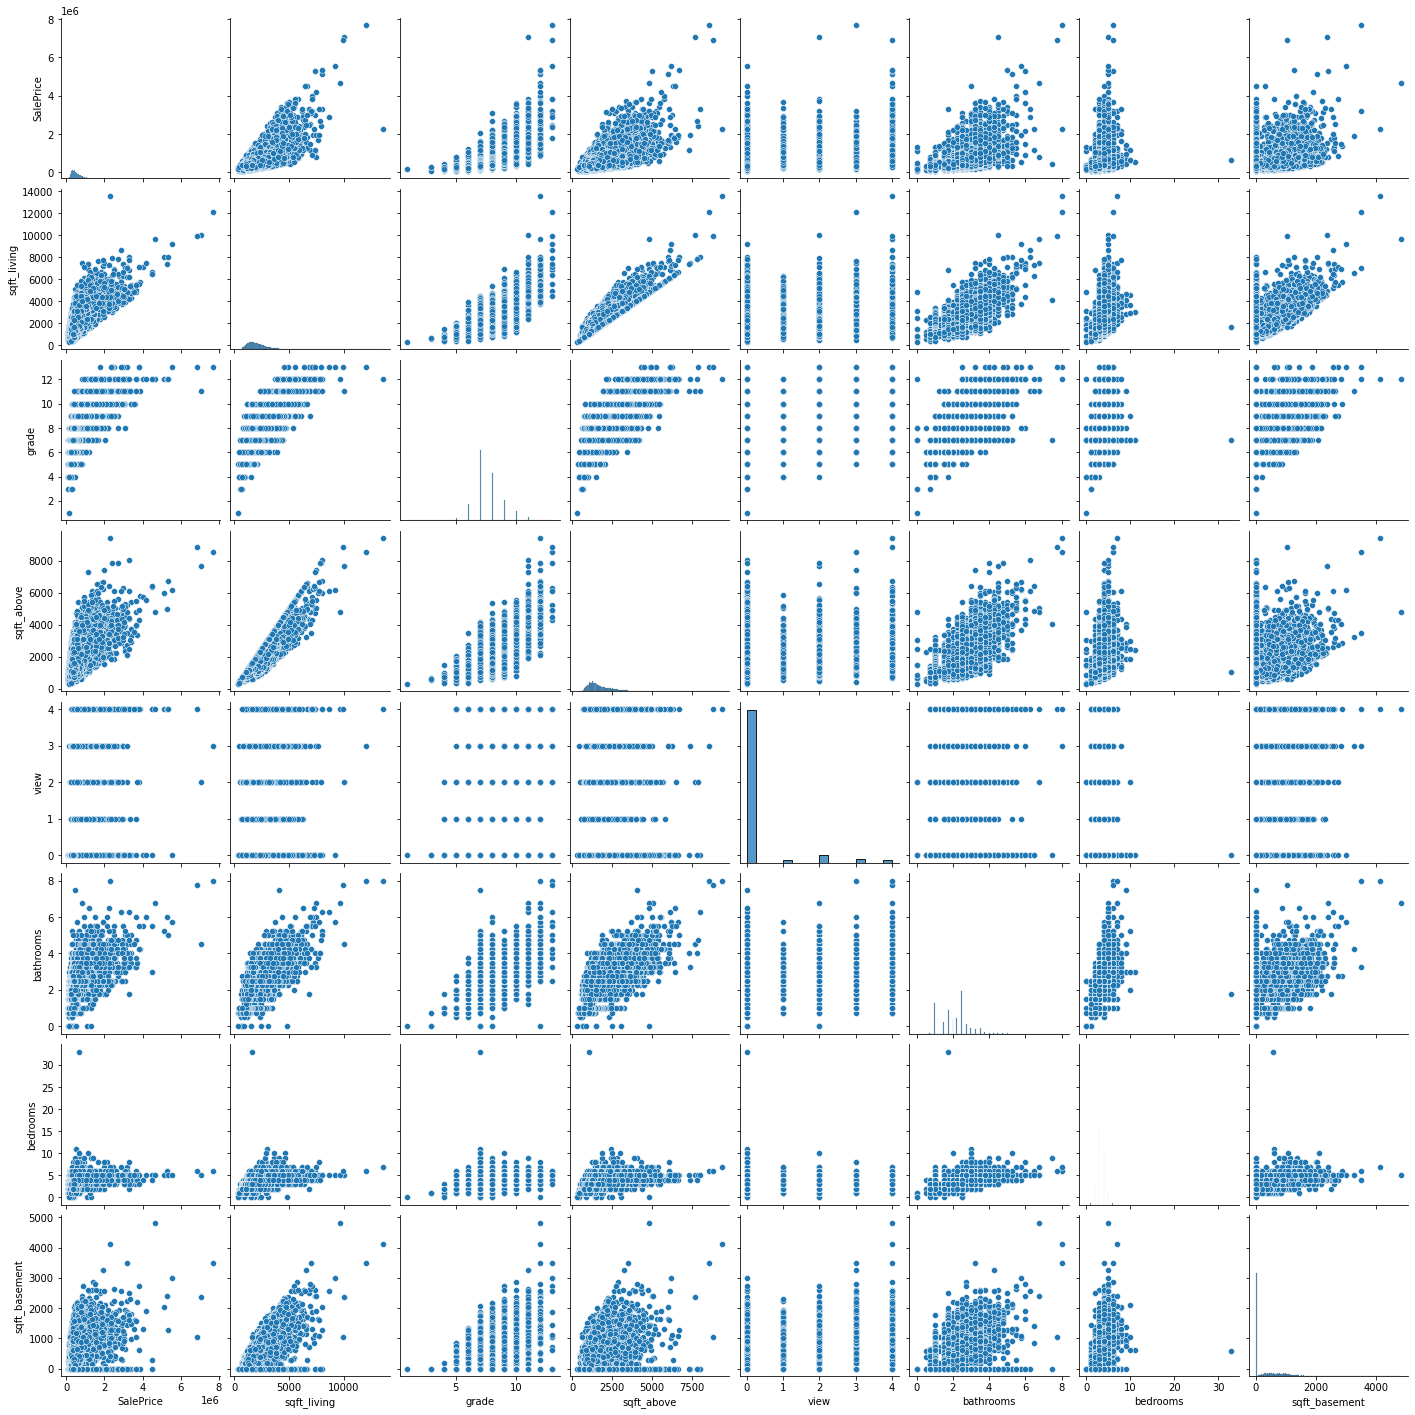

In [40]:
cols=['SalePrice','sqft_living','grade','sqft_above','view','bathrooms','bedrooms','sqft_basement']
sns.pairplot(df_train[cols])
plt.show()

In [41]:
new_data = df_train[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms',
                     'view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']]

In [42]:
X=new_data.values
y=df_train.SalePrice.values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [45]:
from sklearn.metrics import accuracy_score

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf_reg=RandomForestRegressor(n_estimators=400,random_state=0) 
start=time()
rf_reg.fit(X_train,y_train)
end=time()
train_time_rf=end-start
rf_score=rf_reg.score(X_test,y_test)
predrf=rf_reg.predict(X_test)
r2rf = r2_score(y_test,predrf)

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
start=time()
gb=GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1)
gb.fit(X_train,y_train)
end=time()
train_time_g=end-start
gradient=gb.score(X_test,y_test)
pred=gb.predict(X_test)
exp_gb=explained_variance_score(pred,y_test)

In [59]:
from sklearn.tree  import DecisionTreeRegressor
decision=DecisionTreeRegressor()
start = time()
decision.fit(X_train, y_train)
end=time()
train_time_dec=end-start
decc=decision.score(X_test,y_test)
decpredict = decision.predict(X_test)
exp_dec = explained_variance_score(decpredict,y_test)

In [60]:
from sklearn.ensemble import AdaBoostRegressor
start = time()
ada=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
end=time()
train_time_ada=end-start
adab=ada.score(X_test,y_test)
predict = ada.predict(X_test)
exp_ada = explained_variance_score(predict,y_test)

In [62]:
model=pd.DataFrame({
    'Model':['GradientBoosting','AdaBoost','RandomForest','DecisionTree'],
    'Score':[gradient,adab,rf_score,decc],
    'Variance_Score':[exp_gb,exp_ada,r2rf,exp_dec]
})
model.sort_values(by='Score',ascending=False)

,Model,Score,Variance_Score
0,GradientBoosting,0.860855,0.860034
2,RandomForest,0.846605,0.846605
3,DecisionTree,0.684788,0.717394
1,AdaBoost,0.620287,0.502249


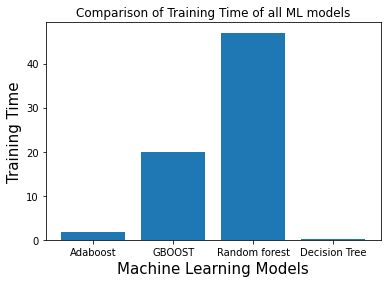

In [63]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Adaboost', 'GBOOST', 'Random forest', 'Decision Tree']
Train_Time = [
    train_time_ada,
    train_time_g,
    train_time_rf,
    train_time_dec
    
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=10, )
plt.title('Comparison of Training Time of all ML models')
plt.show()

In [64]:
X.shape

(21613, 12)